<style>
h1 {text-align: center; font-family: Georgia; font-size: 36px; font-weight: bold; line-height: 48px}
h2 {font-family: Calisto MT; font-size: 30px; font-weight: bold; color: #6a085c}
h3 {font-family: Lucida Bright; font-size: 24px; font-weight: bold; color: #114a4f}
h4 {text-indent: 2em; font-family: Cambria; font-size: 18px}
p.text {text-indent: 2em; text-align: justify; font-family: Times New Roman; font-size: 20px}
p.ex {text-align: center; font-family: Times New Roman; font-size: 20px}
table.t {width: 80%; border: 1px solid; padding: 5px; border-collapse: collapse}
th.h {text-align: left; font-family: Georgia; font-size: 18px; border: 1px solid; padding: 5px}
td.d {text-align: left; font-family: Cambria; font-size: 18px; border: 1px solid; padding: 5px}
code {font-family: monospace; font-weight: bold; font-size: 16px; color: crimson; padding: 4px}
</style>

<h1>Formalizing Informal Text using Natural Language Processing</h1>

In [1]:
import re
import joblib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
title_font = {'family': 'serif', 'color': 'darkred', 'weight': 'bold', 'size': 18}
label_font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
import warnings
warnings.filterwarnings("ignore")

<h3>Loading data:</h3>


In [2]:
# Reading the file
f = open("informaltoformal.en2nen2cn", "r", encoding = 'utf-8')
text = f.read()

# Removing last instance after splitting as it is empty string
text = text.split('\n')[:-1]

# Creating the pandas dataframe
data = [[text[i], text[i+1]] for i in list(range(0, 6000, 3))]
df = pd.DataFrame(data, columns = ['Informal text', 'Formal text'])
df.head()

,Informal text,Formal text
0,"U wan me to ""chop"" seat 4 u nt?",Do you want me to reserve seat for you or not?
1,Yup. U reaching. We order some durian pastry a...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,They become more expensive already. Mine is li...
3,I'm thai. what do u do?,I'm Thai. What do you do?
4,Hi! How did your week go? Haven heard from you...,Hi! How did your week go? Haven't heard from y...


In [3]:
# Creating encoder inp, decoder inp and decoder_out 
encoder_inp = '<' + df['Informal text'].astype(str) + '>'
decoder_inp = '<' + df['Formal text'].astype(str)
decoder_out = df['Formal text'].astype(str) + '>'

# Creating the dataframe
preprocessed_data = pd.DataFrame()
preprocessed_data['encoder_inp'] = encoder_inp
preprocessed_data['decoder_inp'] = decoder_inp
preprocessed_data['decoder_out'] = decoder_out
preprocessed_data.head()

,encoder_inp,decoder_inp,decoder_out
0,"<U wan me to ""chop"" seat 4 u nt?>",<Do you want me to reserve seat for you or not?,Do you want me to reserve seat for you or not?>
1,<Yup. U reaching. We order some durian pastry ...,<Yeap. You reaching? We ordered some Durian pa...,Yeap. You reaching? We ordered some Durian pas...
2,<They become more ex oredi... Mine is like 25....,<They become more expensive already. Mine is l...,They become more expensive already. Mine is li...
3,<I'm thai. what do u do?>,<I'm Thai. What do you do?,I'm Thai. What do you do?>
4,<Hi! How did your week go? Haven heard from yo...,<Hi! How did your week go? Haven't heard from ...,Hi! How did your week go? Haven't heard from y...


<h3>Splitting the data into training and validation sets:</h3>

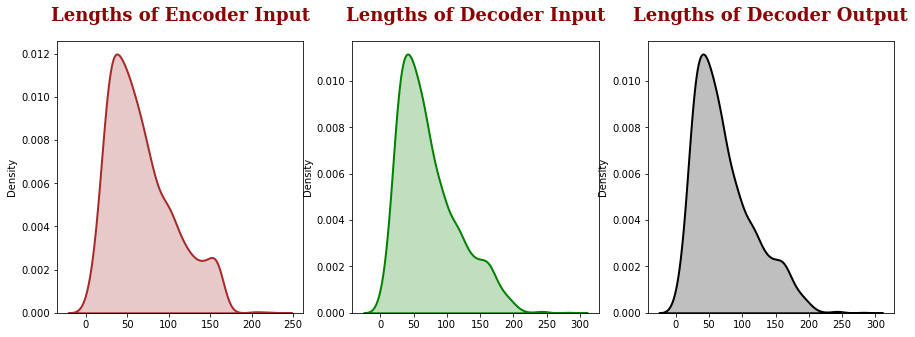

In [4]:
# creating axes to draw plots
fig, ax = plt.subplots(1, 3)

# plotting the distributions
sns.distplot(preprocessed_data['encoder_inp'].apply(len).values, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "brown", ax = ax[0])
sns.distplot(preprocessed_data['decoder_inp'].apply(len).values, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "green", ax = ax[1])
sns.distplot(preprocessed_data['decoder_out'].apply(len).values, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "black", ax = ax[2])

# adding titles to the subplots
ax[0].set_title("Lengths of Encoder Input", fontdict = title_font, pad = 20.0)
ax[1].set_title("Lengths of Decoder Input", fontdict = title_font, pad = 20.0)
ax[2].set_title("Lengths of Decoder Output", fontdict = title_font, pad = 20.0)

# rescaling the figure
fig.set_figheight(5)
fig.set_figwidth(15)

<p class = "text">
As we can see, most of the sentences are of length around 50 and almost all the sentences have lengths less than 40. Hence, we can filter out the sentences which are of length more than 200.
</p>

In [5]:
# Filtering out sentences of length more than 200
preprocessed_data = preprocessed_data[preprocessed_data['encoder_inp'].str.split().apply(len) <= 200]
preprocessed_data = preprocessed_data[preprocessed_data['decoder_inp'].str.split().apply(len) <= 200]
preprocessed_data = preprocessed_data[preprocessed_data['decoder_out'].str.split().apply(len) <= 200]
preprocessed_data.head()

,encoder_inp,decoder_inp,decoder_out
0,"<U wan me to ""chop"" seat 4 u nt?>",<Do you want me to reserve seat for you or not?,Do you want me to reserve seat for you or not?>
1,<Yup. U reaching. We order some durian pastry ...,<Yeap. You reaching? We ordered some Durian pa...,Yeap. You reaching? We ordered some Durian pas...
2,<They become more ex oredi... Mine is like 25....,<They become more expensive already. Mine is l...,They become more expensive already. Mine is li...
3,<I'm thai. what do u do?>,<I'm Thai. What do you do?,I'm Thai. What do you do?>
4,<Hi! How did your week go? Haven heard from yo...,<Hi! How did your week go? Haven't heard from ...,Hi! How did your week go? Haven't heard from y...


<p class = "text">
We can now split the data into train, validation and test sets. As we have less data, we will split with about 90:05:05 split to use more data to train the model.
</p>

In [14]:
train, validation = train_test_split(preprocessed_data, test_size=0.05, random_state = 859)

train, test = train_test_split(train, test_size=0.05, random_state = 859)

joblib.dump(train, 'train.pkl')
joblib.dump(validation, 'validation.pkl')
joblib.dump(test, 'test.pkl')

print(f"Shape of Training set: {train.shape}")
print(f"Shape of Validation set: {validation.shape}")
print(f"Shape of Test set: {test.shape}")

# for one sentence we will be adding '>' token so that the tokanizer learns the word '>'
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['encoder_inp']= str(train.iloc[0]['encoder_inp']) + '>'

Shape of Training set: (1805, 3)
Shape of Validation set: (100, 3)
Shape of Test set: (95, 3)


<h3>Tokenizing data:</h3>

In [15]:
# Tokenizing informal data with case preservation and excluding common punctuations like .,?!:;
tknizer_informal = Tokenizer(filters = '"#$%&()*+-/=@[\\]^_`{|}~\t\n', lower = False, char_level = True)
tknizer_informal.fit_on_texts(train['encoder_inp'].values)
joblib.dump(tknizer_informal, 'tknizer_informal.pkl')

# Tokenizing formal data with case preservation and excluding common punctuations like .,?!:;
tknizer_formal = Tokenizer(filters = '"#$%&()*+-/=@[\\]^_`{|}~\t\n', lower = False, char_level = True)
# Introducing '<end>' token on first sentence so that vocabulary learns it
train['decoder_inp'].iloc[0] = train['decoder_inp'].iloc[0] + '>'
tknizer_formal.fit_on_texts(train['decoder_inp'].values)
joblib.dump(tknizer_formal, 'tknizer_formal.pkl')

# Printing sizes of vocabularies
vocab_size_informal = len(tknizer_informal.word_index.keys())
print(f"Vocab size of Informal text: {vocab_size_informal}")
vocab_size_formal = len(tknizer_formal.word_index.keys())
print(f"Vocab size of Formal text: {vocab_size_formal}")

Vocab size of Informal text: 103
Vocab size of Formal text: 91


<h3>Padding data:</h3>

In [16]:
# Encoding the sentences by numerical ids in place of words
encoder_seq = tknizer_informal.texts_to_sequences(train['encoder_inp'].values)
decoder_inp_seq = tknizer_formal.texts_to_sequences(train['decoder_inp'].values)
decoder_out_seq = tknizer_formal.texts_to_sequences(train['decoder_out'].values)
# Padding the sentences to make all the sentences of same length
encoder_seq = pad_sequences(encoder_seq, maxlen = 40, dtype='int32', padding='post')
decoder_inp_seq = pad_sequences(decoder_inp_seq, maxlen = 40, dtype='int32', padding='post')
decoder_out_seq = pad_sequences(decoder_out_seq, maxlen = 40, dtype='int32', padding='post')